# MESSI Cluster Analysis

Here, the default features are altered to *diff*, *mean* & *altitude* (since *diff* & *std* showed high correlation). Then, the kmeans-clustering process is repeated.

In [44]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from IPython.display import display
import imageio
sns.set_theme()

In [ ]:
# TODO
# Ist es sinnvoll, die Höhe als feature zu benutzen oder sollte nicht vielmehr
# eines der Cluster die Höhe widerspiegeln?

In [2]:
# data import
tmp_ftrs = pd.read_csv("../data/tmp_ftrs.csv")
messi_loc = pd.read_csv("../data/messi_location_clean.csv")

Since we're changing the feature space, it might be worth a try to repeat the *elbow method* to find optimal number of clusters.

In [35]:
ftrs = ["diff", "mean", "alt"]

# kmeans cannot handle missing values, rows containing missing values are going
# to be removed
day23 = tmp_ftrs[tmp_ftrs.day == 23].dropna() # again, starting with 23 April
day23_ftrs = day23[ftrs].values # convert to numpy array

sse_per_k = {}
for k in range(1,11):
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++", # initializes the centroids to be (generally) distant from each other
        n_init=10,        # # of times kmeans is run with different centroid seeds
        random_state=42,  # for reproducibility
    ).fit(         # here, compute k-means clustering
        day23_ftrs # <- shape (n_samples, n_features)
    )
    # output some information
    print(
        "# of clusters", k,
        "\t# of iterations:", kmeans.n_iter_,
        "\t# of features:", kmeans.n_features_in_
    )
    # and save evaluation metric
    sse_per_k[k] = kmeans.inertia_ # sum of squared distances

# of clusters 1 	# of iterations: 2 	# of features: 3
# of clusters 2 	# of iterations: 3 	# of features: 3
# of clusters 3 	# of iterations: 7 	# of features: 3
# of clusters 4 	# of iterations: 5 	# of features: 3
# of clusters 5 	# of iterations: 3 	# of features: 3
# of clusters 6 	# of iterations: 3 	# of features: 3
# of clusters 7 	# of iterations: 2 	# of features: 3
# of clusters 8 	# of iterations: 2 	# of features: 3
# of clusters 9 	# of iterations: 2 	# of features: 3
# of clusters 10 	# of iterations: 2 	# of features: 3


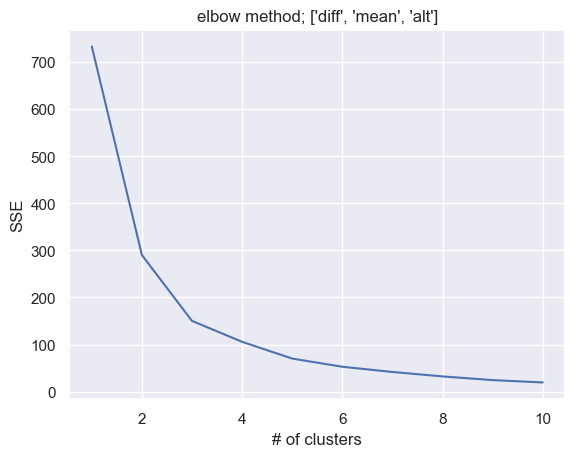

In [37]:
fig, ax = plt.subplots()
ax.plot(list(sse_per_k.keys()), list(sse_per_k.values()))
ax.set_title(f"elbow method; {ftrs}")
ax.set_xlabel("# of clusters")
ax.set_ylabel("SSE");
fig.savefig("../figs/elbow-alt.png", dpi=300, bbox_inches="tight")

This time though, it looks like $k=3$ is optimal number of clusters.

**NOTE**: The *SSE* values for different feature spaces cannot be compared directly as the distance depends on the "spread" of the feature, i.e, *alt* differs a lot among MESSIs, hence, the SSE is larger.

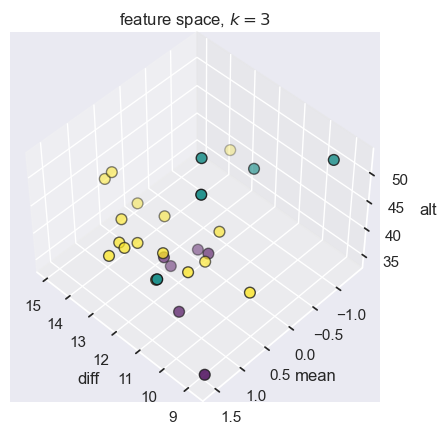

In [39]:
# repeat kmeans with 3 clusters
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10, 
                random_state=42).fit(day23_ftrs)

# and visualise clusters in feature space
fig, ax = plt.subplots(subplot_kw={"projection": "3d", "elev": 48, "azim": 134})
ax.scatter(day23_ftrs[:, 0], day23_ftrs[:, 1], day23_ftrs[:, 2],
           c=kmeans.labels_, edgecolor="k", cmap="viridis", s=60)
ax.set_xlabel(ftrs[0])
ax.set_ylabel(ftrs[1])
ax.set_zlabel(ftrs[2])
ax.set_title(rf"feature space, $k={n_clusters}$");

Running kmean-clustering.

In [40]:
def kmeans_for_single_day(day, n_clusters=n_clusters, ftrs=ftrs):
    """
    Computes kmean for single day and plots clusters on berlin map.
    """
    # kmeans cannot handle missing values, rows containing missing values are
    # going to be removed
    oneday = tmp_ftrs[tmp_ftrs.day == day].dropna()
    oneday_ftrs = oneday[ftrs].values # convert to numpy array

    # compute kmean
    kmeans = KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        n_init=10, 
        random_state=42
    ).fit(oneday_ftrs)

    print(
        "kmeans for day #"+str(day),
        "\n\t> SSE =",kmeans.inertia_,
        "\n\t> # of iters =",kmeans.n_iter_,
    )

    # the order of messis does not change, hence, adding labels to dataframe is
    # as simple as:
    oneday["label"] = kmeans.labels_
    # add messi location data -> new data frame for plotting section
    data = oneday.merge(right=messi_loc[["id", "lon", "lat"]], 
                        how="left", on="id")

    # plotting...
    trans = ccrs.PlateCarree() # do not change!
    bg = cimgt.OSM() # background map

    fig, ax = plt.subplots(subplot_kw={"projection": bg.crs})
    ax.set_extent([13.0, 13.7, 52.65, 52.37], crs=trans)
    sns.scatterplot(data=data, x="lon", y="lat", hue="label", style="label",
                    palette="viridis", s=50, linewidth=0.5, ec="k", alpha=0.9,
                    transform=trans, ax=ax) #legend=False
    ax.add_image(bg, 12, alpha=0.9)
    ax.set_title(f"day = {day}")
    fig.savefig(f"../figs/clusters/loc-cluster-alt-{day}.png", dpi=300, 
                bbox_inches="tight")
    plt.close() # to prevent memory overflow

    # save sum of squared distances
    return kmeans.inertia_

In [41]:
days = tmp_ftrs["day"].unique()
sse = {}

for day in days:
    sse[day] = kmeans_for_single_day(day)

kmeans for day #1 
	> SSE = 253.20493754032412 
	> # of iters = 2
kmeans for day #2 
	> SSE = 270.46895916412655 
	> # of iters = 3
kmeans for day #3 
	> SSE = 390.69730340249276 
	> # of iters = 2
kmeans for day #4 
	> SSE = 677.143971189531 
	> # of iters = 2
kmeans for day #5 
	> SSE = 624.5268329958361 
	> # of iters = 3
kmeans for day #6 
	> SSE = 326.41188180350485 
	> # of iters = 2
kmeans for day #7 
	> SSE = 333.62507687667176 
	> # of iters = 3
kmeans for day #8 
	> SSE = 545.0565682477653 
	> # of iters = 2
kmeans for day #9 
	> SSE = 247.04361435806834 
	> # of iters = 2
kmeans for day #10 
	> SSE = 222.70711764692692 
	> # of iters = 2
kmeans for day #11 
	> SSE = 195.14646800467028 
	> # of iters = 2
kmeans for day #12 
	> SSE = 224.52497669920206 
	> # of iters = 4
kmeans for day #13 
	> SSE = 279.81936109243065 
	> # of iters = 6
kmeans for day #14 
	> SSE = 175.72960196964232 
	> # of iters = 2
kmeans for day #15 
	> SSE = 265.74404539509993 
	> # of iters = 2
kmeans f

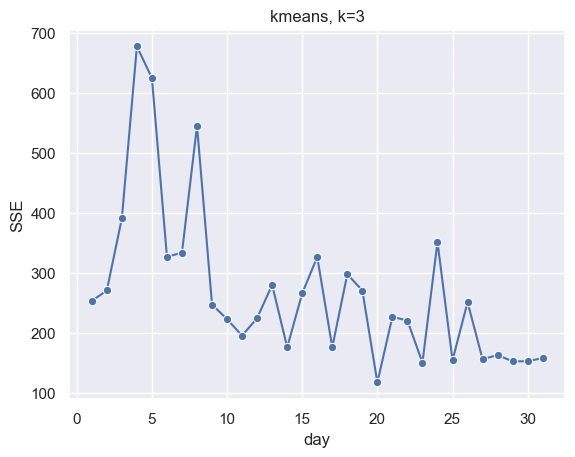

In [43]:
fig, ax = plt.subplots()
sns.lineplot(x=list(sse.keys()), y=list(sse.values()), marker="o")
ax.set_title(f"kmeans, k={n_clusters}")
ax.set_xlabel("day")
ax.set_ylabel("SSE");

In [45]:
# save single frames into array
frames = []
for day in days:
    image = imageio.v2.imread(f"../figs/clusters/loc-cluster-{day}.png")
    frames.append(image)

# combine frames to gif
imageio.mimsave("../figs/clusters/loc-cluster-alt.gif", frames, duration=1.5)

***

Whenever one particuar MESSI is present on a day, it gets its own cluster. Might be a data point with considerable high/low altitude?

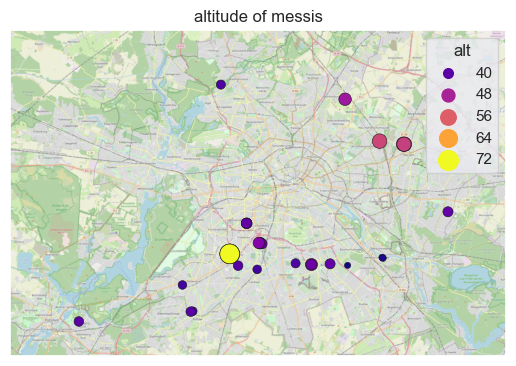

In [68]:
# visualizing height
trans = ccrs.PlateCarree() # do not change!
bg = cimgt.OSM() # background map

fig, ax = plt.subplots(subplot_kw={"projection": bg.crs})
ax.set_extent([13.0, 13.7, 52.65, 52.37], crs=trans)

sns.scatterplot(data=messi_loc, x="lon", y="lat", size="alt", hue="alt",
                sizes=(20, 200), palette="plasma", ec="k", lw=0.5, transform=trans, ax=ax)

ax.add_image(bg, 12, alpha=0.9)
ax.set_title(f"altitude of messis")
fig.savefig(f"../figs/messi-alt.png", dpi=300, bbox_inches="tight")